In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# ml
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# cnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l1_l2

In [2]:
# import data
file_path = '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_4/tf_accessibility_modification.tsv'
tf_data = pd.read_csv(file_path, sep='\t')

In [3]:
tf_data
# TFs can bind at co-regulatory sites
# DNase accessibility indicates open chromatin regions where TFs bind
# H3k27ac is histone modification marking active enhancers that 
# can correlate with TF binding and accessibility 

,DNA_sequence,TF1,TF2,DNase_accessibility,H3K27ac
0,GATTACGAGATACAAATATATATCCAATTTCTACTAGCAATTATAA...,1,0,1,0
1,CTACGAATTGCGATGCATATTTAATAGAAAATGTATACATTTTGCT...,0,0,0,0
2,AAAAAATTAATTGAACAGCGTTTAAAATCTATGGGGTCTTGAGGCA...,0,0,0,0
3,TAGGTTGTCCCAGCCTTTAACTGTTCTCTATTGATGTTTATGTTTG...,0,0,0,0
4,ATTCAACTTTTACTAATCACTGGTTAGGTCTTATTCTGCGTTGTAC...,0,0,0,0
...,...,...,...,...,...
3995,ATAAACAATAGAATTTCTTGATATGTAGCATCGCATTCTCTATACA...,0,0,0,0
3996,TTAGATTCGTGTATAGTAAGTATACAATGATTGGGCGGACCCGGTA...,1,1,1,0
3997,TGGTGCGAAGGTGCCCATTTTGATTTATATATGCCTTTATGGCACG...,1,1,0,0
3998,CATTCTCGTGAAGAAATATCTCCAAATAACATATATATACTCCTTA...,1,1,1,0


# Q1: Exploring Data Distribution and Relationships [2 pts]

In [4]:
tf_data.head()

,DNA_sequence,TF1,TF2,DNase_accessibility,H3K27ac
0,GATTACGAGATACAAATATATATCCAATTTCTACTAGCAATTATAA...,1,0,1,0
1,CTACGAATTGCGATGCATATTTAATAGAAAATGTATACATTTTGCT...,0,0,0,0
2,AAAAAATTAATTGAACAGCGTTTAAAATCTATGGGGTCTTGAGGCA...,0,0,0,0
3,TAGGTTGTCCCAGCCTTTAACTGTTCTCTATTGATGTTTATGTTTG...,0,0,0,0
4,ATTCAACTTTTACTAATCACTGGTTAGGTCTTATTCTGCGTTGTAC...,0,0,0,0


1. Compute and visualize the correlation matrix for TF1, TF2, DNase accessibility, and H3K27ac using a heatmap.

In [5]:
no_seq = tf_data.iloc[:,1:]

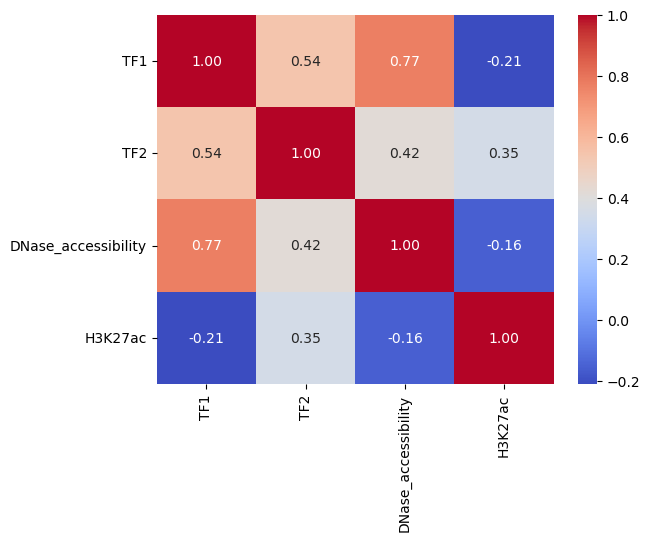

In [6]:
correlations = no_seq.corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

2. Interpret the correlation values:

○ Which features are strongly correlated?

○ Do TF1 and TF2 tend to co-bind?

○ How do accessibility and histone modifications relate to TF binding?

TF_1 and DNAse_accessibility are strongly correlated (0.77) this might indicate that TF_1 has strong or more frequent binding to open chromatin regions. TF_2 has a correlation of 0.42, or a weak correlation with open chromatin regions, suggesting it doesn't bind as well as TF1. 

TF1 and TF might tend to co-bind, since they have a moderate, but positive correaltion of 0.54. 

Accessibility noticeably increases the binding of TF1, but doesn't seem to have as strong a correlation with TF2. 


Histone modifications on the other hand, have a negative correlation with TF-1, but don't impact TF-2 as much. 

The strong correlation between TF_1 and DNAse accessibility (0.77) suggests that DNA accessibility is a key factor influencing TF_1 binding, making it an important feature for predictive modeling of TF_1 activity. In contrast, TF_2’s weaker correlation with DNAse accessibility (0.42) implies that DNA accessibility is less critical for its binding, so other factors might be more important for predicting TF_2. 

The moderate correlation between TF_1 and TF_2 (0.54) suggests that they may co-bind or share regulatory mechanisms, so capturing their joint influence in the model could improve predictions. 

Additionally, histone modifications negatively correlate with TF_1 binding but have little impact on TF_2, indicating that histone modifications should be included as a suppressor for TF_1 but may be irrelevant for TF_2. Because of this, the model should prioritize DNAse accessibility and histone modifications for TF_1. 

Based on the correlations, I think logistic regression would probably perform better than deep learning. The relationships between features like TF binding and DNA accessibility seem to be relatively linear, so logistic regression would capture those well without overfitting. Deep learning could handle more complex relationships, but it might be more likely to risk overfitting if the patterns in the data aren’t as strong. 

# Q2: Logistic Regression for TF Binding and Chromatin Accessibility [2 pts]

In [7]:
#preprocessing
len(tf_data['DNA_sequence'].iloc[0])

# 600 x 4 > should be 2400 columns+4 others > should be 2404 after

600

In [8]:
def encodeMono(sequence):
    monoMap = {"A": [1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    encoded = []
    for mononucleotide in sequence:
        encoded.extend(monoMap[mononucleotide])
    return encoded

In [9]:
encoded_sequences = []
for seq in tf_data['DNA_sequence']:
    encoded = encodeMono(seq)
    encoded_sequences.append(encoded)
    
encoded_df = pd.DataFrame(encoded_sequences)
encoded_df.columns = [f'DNA_seq_{i+1}' for i in range(encoded_df.shape[1])]

encoded_data = pd.concat([encoded_df, tf_data.drop(columns=['DNA_sequence'])], axis=1)

In [10]:
encoded_data.head()
#correct amount of columns

,DNA_seq_1,DNA_seq_2,DNA_seq_3,DNA_seq_4,DNA_seq_5,DNA_seq_6,DNA_seq_7,DNA_seq_8,DNA_seq_9,DNA_seq_10,...,DNA_seq_2395,DNA_seq_2396,DNA_seq_2397,DNA_seq_2398,DNA_seq_2399,DNA_seq_2400,TF1,TF2,DNase_accessibility,H3K27ac
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [11]:
def log_regress(feature,target):
    # split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
    
    # initialize model
    model = LogisticRegression()
    
    # fit model
    model.fit(X_train, y_train)
    
    # make predictions on training and testing data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # accuracy
    accuracy_train = accuracy_score(y_train, train_pred)
    accuracy_test = accuracy_score(y_test, test_pred)
    
    #auroc
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

 
    return accuracy_train, accuracy_test, auc_train, auc_test

In [12]:
# make new X, only supposed to be DNA_sequence
feature = encoded_data.iloc[:,list(range(2400))]

In [13]:
# target is TF1
# features is DNA_sequence
target_1 = encoded_data.iloc[:,2400]

f1_ac_train, f1_ac_test, f1_auc_train, f1_auc_test = log_regress(feature, target_1)

In [14]:
print("TF1 training", f1_ac_train, "and testing", f1_ac_test, "accuracies from sequence")
print("TF1 training", f1_auc_train, "and testing", f1_auc_test, "AUROC from sequence")


TF1 training 0.9909375 and testing 0.54 accuracies from sequence
TF1 training 0.9994546103536933 and testing 0.5203697432117458 AUROC from sequence


In [15]:
# target is TF2
# features is DNA_sequence
target_2 = encoded_data.iloc[:,2401]
f2_ac_train, f2_ac_test, f2_auc_train, f2_auc_test = log_regress(feature, target_2)

/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
print("TF2 training", f2_ac_train, "and testing", f2_ac_test, "accuracies from sequence")
print("TF2 training", f2_auc_train, "and testing", f2_auc_test, "AUROC from sequence")

TF2 training 0.9915625 and testing 0.55375 accuracies from sequence
TF2 training 0.9994746763079015 and testing 0.5683712547871141 AUROC from sequence


In [17]:
# target is DNase accessibility
# features is DNA_sequence
target_3 = encoded_data.iloc[:,2402]
f3_ac_train, f3_ac_test, f3_auc_train, f3_auc_test = log_regress(feature, target_3)

In [22]:
print("DNase accessibility training", f3_ac_train, "and testing", f3_ac_test, "accuracies from sequence")
print("DNase accessibility training", f3_auc_train, "and testing", f3_auc_test, "AUROC from sequence")


DNase accessibility training 1.0 and testing 0.58 accuracies from sequence
DNase accessibility training 1.0 and testing 0.4890768092257408 AUROC from sequence


In [19]:
# target is H3K27ac
# features is DNA_sequence
target_4 = encoded_data.iloc[:,2403]

f4_ac_train, f4_ac_test, f4_auc_train, f4_auc_test = log_regress(feature, target_4)

In [23]:
print("H3K27ac training", f4_ac_train, "and testing", f4_ac_test, "accuracies from sequence")
print("H3K27ac training", f4_auc_train, "and testing", f4_auc_test, "AUROC from sequence")

H3K27ac training 1.0 and testing 0.79125 accuracies from sequence
H3K27ac training 1.0 and testing 0.4825186232396281 AUROC from sequence


The easiest to classify are transcription factors. The hardest seemed to be DNase accessibility or H3K27ac, as seen with their lower auroc scores. 

The limitations of logistic regression for this task are working with low-correlation data, and especially since TF binding and chromatin accessibility are non-linearbut logistic regression works best when features and targets have linear relationships. As so, it makes sense that log regression would struggle when features interact nonlinearly or are weakly correlated. 

# Q3: Effect of Hyperparameter Tuning on CNN Performance [3 pts]

Optimize CNN performance through hyperparameter tuning, ensuring the model is trained
well and avoiding overfitting.

1. Hyperparameter Selection:
    
○ Choose a suitable CNN architecture and tune parameters (e.g., filter size,
dropout rate, batch size, learning rate, etc.). Select the values yourself based on
experimentation.

○ Apply techniques discussed to improve generalization and prevent overfitting.


2. Performance Analysis:

○ Train the model for 30 epochs using 80% of training data.

○ Plot the training and validation loss/accuracy over epochs to analyze
learning behavior.

○ Evaluate and compare Accuracy and AUC for TF1, TF2, DNase accessibility,and H3K27ac.

○ Create a bar plot comparing CNN and logistic regression performance from Q2.

In [24]:
# convert to 4000,600
X_seq = np.array(encoded_sequences).reshape(-1, 600, 4, 1)

In [29]:
# cnn 
def create_cnn():
    # sequential architecture because 
    model = Sequential([
        # 32 neurons, 64, tried 64 and 128 but there was too much overfitting for 30 epochs
        Conv2D(32, (5, 2), activation='relu', input_shape=(600, 4, 1), 
               # applying elastic net to prevent overfitting
               kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
        MaxPooling2D(pool_size=(2,1)),  
        
        Conv2D(64, (5, 2), activation='relu', 
               kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
        MaxPooling2D(pool_size=(2,1)),
        
        #dense layer w 128 neurons/relu
        Flatten(),
        Dense(128, activation='relu'),
        
        #using dropout regularization technique from class so model can learn more robust features
        # increased dropout from 0.5 to 0.6 for stronger regularization
        Dropout(0.6),  
        Dense(1, activation='sigmoid')  
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [30]:
# labels for targets
targets = ["TF1", "TF2", "DNase_accessibility", "H3K27ac"]
results_acc = {}
results_auc = {}

In [31]:
def plot_learning_curves(history, target):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title(f"Training vs. Validation Accuracy for {target}")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title(f"Training vs. Validation Loss for {target}")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("loss")
    ax[1].legend()

    plt.show()

/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5756 - loss: 0.8152 - val_accuracy: 0.6050 - val_loss: 0.7585
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.6018 - loss: 0.7574 - val_accuracy: 0.6050 - val_loss: 0.7247
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6194 - loss: 0.7105 - val_accuracy: 0.6612 - val_loss: 0.6944
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7128 - loss: 0.6243 - val_accuracy: 0.7387 - val_loss: 0.5654
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7923 - loss: 0.5195 - val_accuracy: 0.8037 - val_loss: 0.4982
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8263 - loss: 0.4544 - val_accuracy: 0.8288 - val_loss: 0.4491
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8722 - loss: 0.3849 - val_accuracy: 0.8475 - val_loss: 0.4148
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9062 - loss: 0.3118 - val_accu

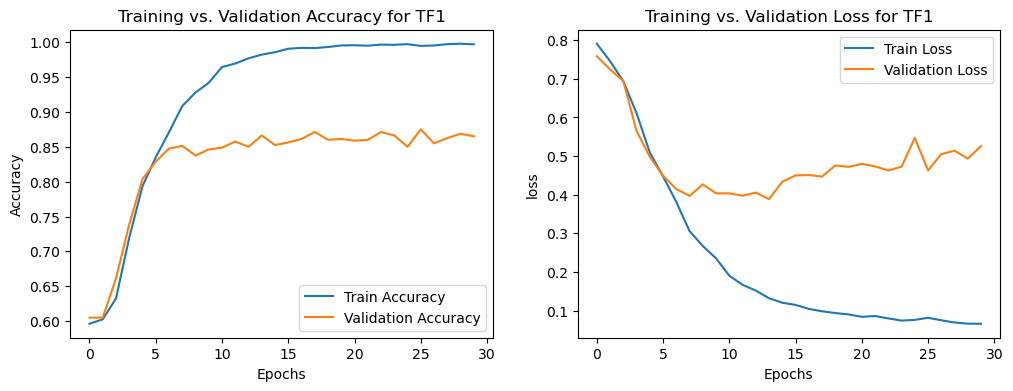

Epoch 1/30


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5086 - loss: 0.8321 - val_accuracy: 0.5188 - val_loss: 0.7779
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5612 - loss: 0.7614 - val_accuracy: 0.6363 - val_loss: 0.6922
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.7150 - loss: 0.6370 - val_accuracy: 0.7887 - val_loss: 0.5471
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8292 - loss: 0.4755 - val_accuracy: 0.8788 - val_loss: 0.3822
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9138 - loss: 0.3312 - val_accuracy: 0.9150 - val_loss: 0.3040
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9455 - loss: 0.2269 - val_accuracy: 0.9287 - val_loss: 0.2503
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9658 - loss: 0.1730 - val_accuracy: 0.9287 - val_loss: 0.2504
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9791 - loss: 0.1467 - val_accuracy: 0.940

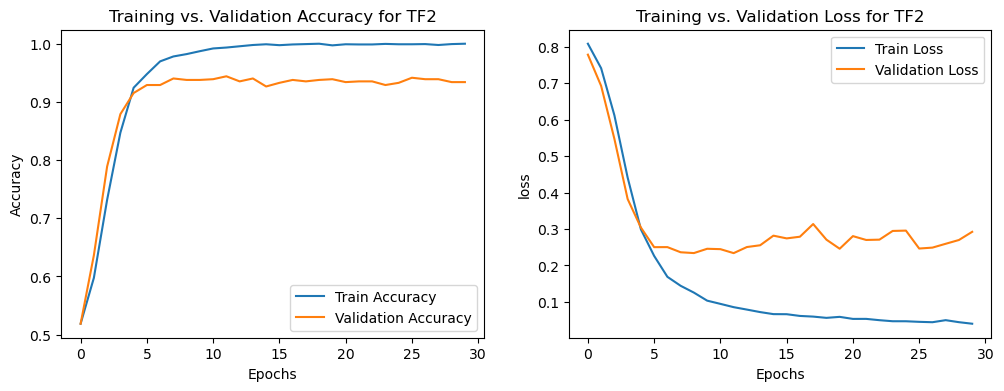

Epoch 1/30


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.7111 - loss: 0.7270 - val_accuracy: 0.7200 - val_loss: 0.7040
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7099 - loss: 0.6919 - val_accuracy: 0.7200 - val_loss: 0.6645
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7194 - loss: 0.6542 - val_accuracy: 0.7200 - val_loss: 0.6397
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7236 - loss: 0.5974 - val_accuracy: 0.7212 - val_loss: 0.6053
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7465 - loss: 0.5375 - val_accuracy: 0.7437 - val_loss: 0.5636
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7965 - loss: 0.4624 - val_accuracy: 0.7513 - val_loss: 0.5281
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.8449 - loss: 0.3936 - val_accuracy: 0.7975 - val_loss: 0.4835
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8765 - loss: 0.3443 - val_accuracy: 0.807

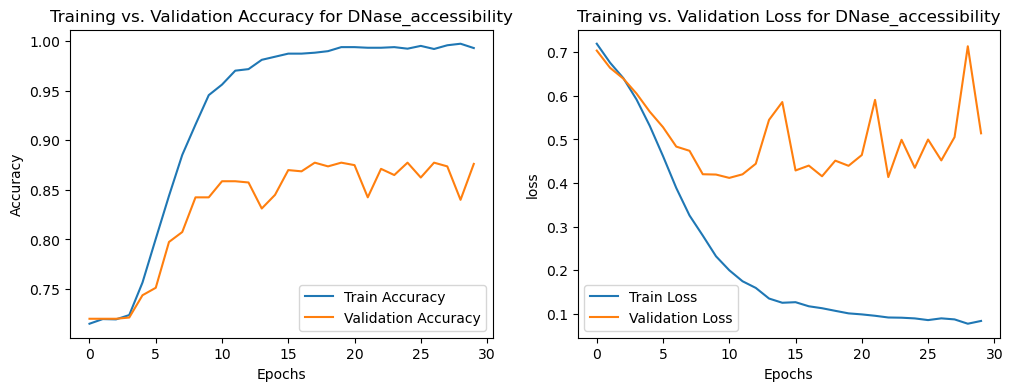

Epoch 1/30


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.8503 - loss: 0.5819 - val_accuracy: 0.8825 - val_loss: 0.4655
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8910 - loss: 0.4558 - val_accuracy: 0.8825 - val_loss: 0.4570
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8754 - loss: 0.4599 - val_accuracy: 0.8825 - val_loss: 0.4371
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8926 - loss: 0.4106 - val_accuracy: 0.8825 - val_loss: 0.4304
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8810 - loss: 0.3994 - val_accuracy: 0.8825 - val_loss: 0.4230
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8829 - loss: 0.3673 - val_accuracy: 0.8825 - val_loss: 0.4270
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8815 - loss: 0.3492 - val_accuracy: 0.8825 - val_loss: 0.4391
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8846 - loss: 0.2961 - val_accuracy: 0.882

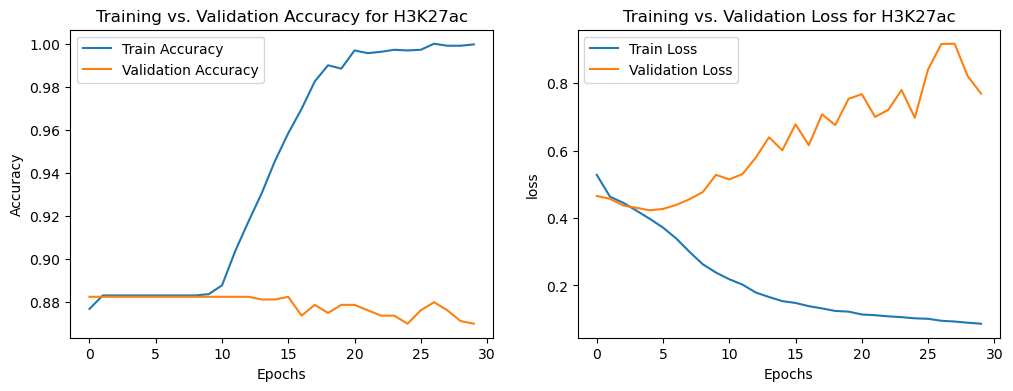

In [32]:
for target in targets:
    labels = tf_data[target].values  

    # split with strat based on target values
    X_train_seq, X_test_seq, y_train, y_test = train_test_split(
        X_seq, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # train CNN model
    model = create_cnn() 
    history = model.fit(
        # train for 30 epochs
        X_train_seq, y_train, epochs=30, batch_size=32, 
        validation_data=(X_test_seq, y_test), verbose=1
    )

    # evaluate CNN model on TEST set
    test_loss, test_acc = model.evaluate(X_test_seq, y_test)
    
    
    #auroc
    y_pred_proba = model.predict(X_test_seq).flatten()
    test_auc = roc_auc_score(y_test, y_pred_proba)
    results_auc[target] = test_auc
    
    # accuracy 
    results_acc[target] = test_acc  
    
    # plotting training and validation loss/accuracy over epochs
    plot_learning_curves(history, target)

    

In [33]:
for target in targets:
    print(target, "Accuracy:", results_acc[target], "Auroc:", results_auc[target])

TF1 Accuracy: 0.8650000095367432 Auroc: 0.9414687728841928
TF2 Accuracy: 0.9337499737739563 Auroc: 0.9796213425129088
DNase_accessibility Accuracy: 0.8762500286102295 Auroc: 0.9190305679563493
H3K27ac Accuracy: 0.8700000047683716 Auroc: 0.5408353926827798


In [ ]:
# logistic regression performance
log_acc = [f1_ac_test, f2_ac_test, f3_ac_test, f4_ac_test]
log_auc = [f1_auc_test, f2_auc_test, f3_auc_test, f4_auc_test]

# CNN performance
cnn_acc = [results_acc["TF1"], results_acc["TF2"], results_acc["DNase_accessibility"], results_acc["H3K27ac"]]
cnn_auc = [results_auc["TF1"], results_auc["TF2"], results_auc["DNase_accessibility"], results_auc["H3K27ac"]]

#  x-axis labels
labels = ["TF1", "TF2", "DNase", "H3K27ac"]
x = np.arange(len(labels))  

In [ ]:
width = 0.2
fig, ax = plt.subplots(figsize=(8, 5))

# accuracy
ax.bar(x - width*1.5, log_acc, width, label='Logistic Regression Accuracy', color='skyblue')
ax.bar(x - width*0.5, cnn_acc, width, label='CNN Accuracy', color='blue')

# AUROC 
ax.bar(x + width*0.5, log_auc, width, label='Logistic Regression AUROC', color='lightcoral')
ax.bar(x + width*1.5, cnn_auc, width, label='CNN AUROC', color='red')

# plot
ax.set_xlabel("Target Labels")
ax.set_ylabel("Performance Score")
ax.set_title("Logistic Regression vs CNN Performance (Accuracy & AUROC)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

After changing around hyperparameters such as number of filters in conv layer and sense layer, as well as dropout layer, it seems two convolution layers with 64 and 128 filters, both with a kernal size of 5x2 seemed to perform with the best accuracy, but with a trade-off for increased loss. 

However, the best overall (less overfitting/loss, okay accuracy) was two convolution layers with 32 and 64 neurons. Also, a dense layer with 128 neurons and dropout of 0.6 seemed to perform well also.  This might be because CNN learns spatial patterns, so too many neurons (64 and 128) might contribute to overfitting. 

I experiented by changing the mixed convolution layer neurons, dropout rate, and added elastic net (l1 and l2 regularization to decrease the overfitting).  From increased neurons (64 and 128), the accuracy seemed to increase for the transcription factors(from 0.87 to 0.91 for TF1 and for 0.94 to 0.96 for TF2), but the loss seemed to increase dramatically overall, especially for for H3K27ac (1.31 loss) which had poor correlations to start. 

As a result, 32 and 64 neurons for the convolution layers, with elastic net regularization and an increase dropout yieled a similar, but slightly lower accuracy overall and a decreased loss/less overfitting even in low correlation features.

The training and validation plots show that targets with higher correlations (TF1 and TF2) have increased accuracy, and generally decreased loss with convergence between training and validation. However across all targets, loss generally is higher in the validation than in the training, this could be a result of overfitting. 

Overall, loss indicates overfitting. In TF1 and TF2 accuracy plots, there is an upwards trend, as the accuracy tends to increase and converge for both training and testing. However in DNase accessibility and H3K27ac, there is more noticeable divergence, indicating overfitting. This overfitting might be because of the poor correlations/non-linear patterns of both targets making it difficult to classify. 

CNN performs better than logistic regression since it's better equipped for working with non-linear or poor-correlation data. CNN performs better across all labels. Log regression likely struggled it's less suited for non-linear data, like the lower correlation labels. On the other hand, CNN performed beter since it was able to extract important patterns from the sequence feature, capturing interations/spatial dependencies that log regression wasn't able to. 

ignore
conv1-32
conv2-64
kernel 5x2
sense - 128
dropout 0.5

TF1 Accuracy: 0.8712499737739563 Auroc: 0.9474382780625588
TF2 Accuracy: 0.9399999976158142 Auroc: 0.9828602722578627
DNase_accessibility Accuracy: 0.8600000143051147 Auroc: 0.9191468253968256
H3K27ac Accuracy: 0.8737499713897705 Auroc: 0.5305285998432885

final:
TF1 Accuracy: 0.8650000095367432 Auroc: 0.9414687728841928
TF2 Accuracy: 0.9337499737739563 Auroc: 0.9796213425129088
DNase_accessibility Accuracy: 0.8762500286102295 Auroc: 0.9190305679563493
H3K27ac Accuracy: 0.8700000047683716 Auroc: 0.5408353926827798


conv1-64
conv2-128
kernel 5x2
sense - 128
dropout 0.5
*took twice as long

TF1 Accuracy: 0.9137499928474426 Auroc: 0.9720159012449001
TF2 Accuracy: 0.9649999737739563 Auroc: 0.9904083867939291
DNase_accessibility Accuracy: 0.9087499976158142 Auroc: 0.9538147941468255
H3K27ac Accuracy: 0.856249988079071 Auroc: 0.5227080947501658


TF1 Accuracy: 0.9137499928474426 Auroc: 0.9720159012449001
TF2 Accuracy: 0.9649999737739563 Auroc: 0.9904083867939291
DNase_accessibility Accuracy: 0.9087499976158142 Auroc: 0.9538147941468255
H3K27ac Accuracy: 0.856249988079071 Auroc: 0.5227080947501658
